In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../')
sys.path.append(root)

import math
import numpy as np

DISTGEN_INPUT_FILE = os.path.join(root, 'templates/distgen/distgen_single_particle.yaml')

# Hard Edge Check

predicted kick: 7.519132533719884e-05


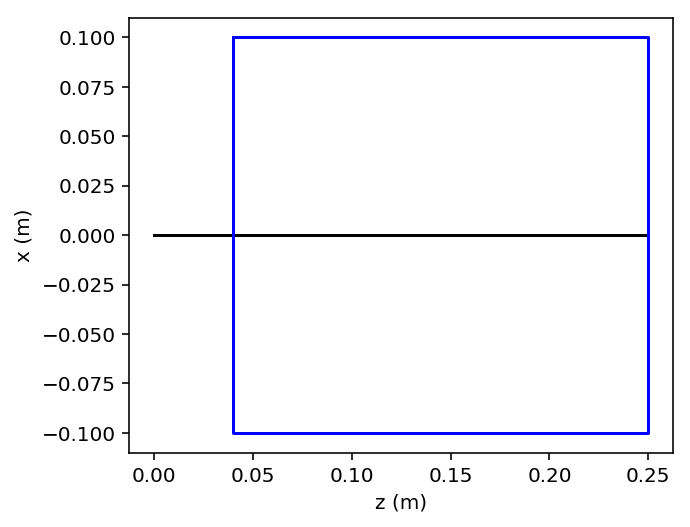

In [36]:
from gpt.element import Lattice
from gpt.bstatic import QuadF

# calculate gamma*beta
mec2 = 0.51099895000e6 # eV
Etot = 6e6 #eV
gamma = Etot/mec2
GB = np.sqrt(gamma**2 -1)

p = GB*mec2/1e6  # [MeV/c]

qgrad = 0.00714  # [T/m]
qlen =  0.21     # [m]

dtheta = qlen*qgrad * (299792458 / (p*1e6)) * .001

print('predicted kick:', dtheta)

lat = Lattice('Single Quad')
lat.add(QuadF('q1', qgrad, qlen), ds=0.04)
lat.plot_floor();

In [50]:
from distgen import Generator
from distgen.physical_constants import unit_registry
from gpt import GPT

gen = Generator(DISTGEN_INPUT_FILE, verbose=0)
gen.input['transforms']={
    'set_pz':{'type':'set_avg pz', 'avg_pz':{'value': p, 'units': 'MeV/c'}},
    'set_x':{'type':'set_avg x', 'avg_x':{'value': 1, 'units': 'mm'}},
}

gen['n_particle']=10
gen.run()
pg = gen.particles

lat.write_gpt_lines(output_file='gpt.temp.in')

G = GPT(input_file='gpt.temp.in', initial_particles=pg)
G.set_variables({'space_charge':0, 'xacc':12, 'GBacc':12})
G.run()

Computed kick: 7.538815100369447e-05


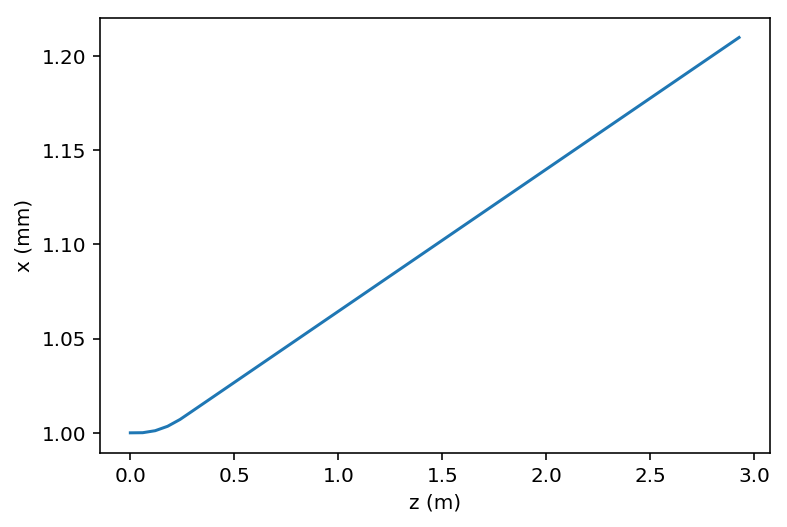

In [51]:
plt.plot(G.stat('mean_z'), G.stat('mean_x')*1000)
plt.xlabel('z (m)');
plt.ylabel('x (mm)');

final_particles = G.tout[-1]

px = final_particles['mean_px']
pz = final_particles['mean_pz']

print('Computed kick:', px/pz)